# Guide

Check the guide carefully before starting.

## ILOs

After completing this lab you should be able to 

* implement applications of word embeddings
* recognise biases and stereotypes that skip-gram models carry over from the data used to train them.


## General notes

* In this notebook you are expected to use $\LaTeX$. 
* Use python3.

We will use a set of standard libraries that are often used in machine learning projects. If you are running this notebook on Google Colab, all libraries should be pre-installed. If you are running this notebook locally you will need to install some additional packages, ask your TA for help if you have problems setting up.

## Table of contents

* [Word Embeddings](#emb)
    * [Vocabulary](#vocab)
    * [Embedding matrix](#matrix)
* [Applications of word embeddings](#applications)
* [Bias in embeddings](#bias)


## Table of graded exercises

Exercises have equal weights.

* [Applications of word embeddings](#ex-applications)
* [Bias in embeddings](#ex-bias)

## How to use this notebook

Check the entire notebook before you get started, this gives you an idea of what lies ahead.

Note that, as always, the notebook recaps theory, and contains solved quizzes. While you should probably make use of this theory recap, be careful not to spend disproportionately more time on this than you should. 


## Setting up

Here we set up the packages that you will need to install for this tutorial.

In [1]:
!pip install seaborn
!pip install sklearn
!pip install gensim

'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.
'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
## Standard libraries
import os
import gzip
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

C:\Users\timpi\AppData\Local\Temp\ipykernel_22416\3930292937.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


# <a name="emb"/> Word Embeddings

A *word embedding* is a continuous vector representation of a word, typically optimised to capture an aspect of that word's usage in natural language data. 

Notation:
* $\mathcal W$ is a vocabulary of known words;
* $w \in \mathcal W$ is a known word;
* $\mathrm{emb}(w; \theta) \in \mathbb R^D$ is the $D$-dimensional representation of $w$ by an embedding function $\mathrm{emb}(\cdot; \theta)$ with parameters $\theta$;

For a finite vocabulary of known words (let's use $V = |\mathcal W|$ as the vocabulary size), we can store this embedding function using a table $\mathbf E \in \mathbb R^{V\times D}$, where each row stores the $D$-dimensional vector representation of one of the known words (we also need to store the 1-to-1 mapping between known words and row indices). 

Assuming this table is stored in memory, we can obtain the word embedding for a known word $w$ in different ways. For example, if we can use a dictionary lookup to obtain the row number associated with a known word, $i = \mathrm{lookup}(w)$, and then use the row number to retrieve the correct word vector $\mathbf E_i$.

We will start by manipulating embeddings stored this way, for that we will create both the vocabulary dictionary (a python class) and the embedding matrix (a numpy array).

## <a name="vocab"/> Vocabulary

Let's start by creating a data structure to manage a vocabulary of known words. 

This data structure can:
* encode a token (a string) as a code (an integer)
* decode a code (an integer) into a token (a string) 


In [3]:
class Vocabulary:
    """A vocabulary, assigns IDs to tokens"""

    def __init__(self, unk_token="<unk>"):
        # we reserve position 0 for a placeholder token for words never seen before
        self.unk_token = unk_token
        self.w2i = {unk_token: 0}
        self.i2w = [unk_token]
        
    def __len__(self):
        """Return the number of known symbols (including any placeholder symbols)"""
        return len(self.i2w)
        
    def add(self, token: str):
        """Add a token to the vocabulary (if not there) and return its code."""
        i = self.w2i.get(token, None)
        if i is None:
            i = len(self.i2w)
            self.i2w.append(token)
            self.w2i[token] = i
        return i
    
    def encode(self, token: str):
        """Return the numerical code of a token. Unknown tokens are mapped to the code of the unk_token string"""
        return self.w2i.get(token, self.w2i[self.unk_token])
    
    def decode(self, key: int):
        """Return the string associated with a code. Unknown codes are mapped to unk_token."""
        return self.i2w[key] if key < len(self.i2w) else self.unk_token
    
    def __getitem__(self, token: str):
        """Return the code of a known token (an exception is thrown if the token isn't known)"""
        return self.w2i[token]
    
    def __contains__(self, token: str):
        return token in self.w2i

Here's a demonstration of the class:

In [4]:
example_vocab = Vocabulary()

print("Beforing adding tokens to the vocabulary encode will return 0:")
for w in 'the coolest things are also the most rewarding'.split():
    print("", w, example_vocab.encode(w))

print("\nAs we add tokens, strings are mapped to codes one-to-one:")    
for w in 'the coolest things are also the most rewarding'.split():
    print("", w, example_vocab.add(w))
    
print("\nAnd now encode will return those codes too:")
for w in 'the coolest things are also the most rewarding'.split():
    print("", w, example_vocab.encode(w))    
    
print("\nDecode reverses the mapping:")
for i in range(len(example_vocab)):
    print("", i, example_vocab.decode(i)) 

print(f"\nUnknown symbols are mapped to 0, for example here's the code for 'NTMI':", example_vocab.encode("NTMI"))
print(f"\nUnknown codes are mapped to unk_token, for example here's the token for 1000:", example_vocab.decode(1000))

Beforing adding tokens to the vocabulary encode will return 0:
 the 0
 coolest 0
 things 0
 are 0
 also 0
 the 0
 most 0
 rewarding 0

As we add tokens, strings are mapped to codes one-to-one:
 the 1
 coolest 2
 things 3
 are 4
 also 5
 the 1
 most 6
 rewarding 7

And now encode will return those codes too:
 the 1
 coolest 2
 things 3
 are 4
 also 5
 the 1
 most 6
 rewarding 7

Decode reverses the mapping:
 0 <unk>
 1 the
 2 coolest
 3 things
 4 are
 5 also
 6 most
 7 rewarding

Unknown symbols are mapped to 0, for example here's the code for 'NTMI': 0

Unknown codes are mapped to unk_token, for example here's the token for 1000: <unk>


## <a name="matrix"/> Embedding matrix

In this section we will download a collection of already trained word embeddings. We use [GloVe](https://nlp.stanford.edu/projects/glove/) vectors which have been trained using text downloaded from the English Wikipedia. GloVe is very similar (though not identical) to skip-gram that we discussed in class. The details aren't important for this tutorial. To keep this demonstration lightweight we are using 50-dimensional vectors. These *aren't* the best word vectors you can find for English Wikipedia, later in this tutorial you will be able to use better ones.

We provide helper code to download the embeddings and build an np.array.

In [5]:
def load_embeddings(path):
    """
    Load word embeddings and update vocab.
    :param path: path to word embedding file
    :return: a Vocabulary object and an np.array with shape (vocab_size, dim)
    """
    if not os.path.exists(path):
        raise RuntimeError("You need to download the word embeddings")
    vocab = Vocabulary()
    vectors = []
    w2i = {}
    i2w = []

    # Placeholder vector for the unknown word 
    # (once we have all word vectors we will set this to the average embedding)
    vectors.append(None)

    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            word, vec = line.split(u' ', 1)
            assert word not in vocab.w2i, "repeated word"
            vocab.add(word)  
            v = np.array(vec.split(), dtype=np.float32)
            vectors.append(v)
            
    # fix the embedding of the unknown word to the average embedding
    vectors[0] = np.mean(vectors[1:], axis=0)

    return vocab, np.array(vectors)

Let's download some word embeddings (these have been trained using English Wikipedia data):

In [6]:
import os

if not os.path.exists("glove.6B.50d.txt.gz"):
    !wget -q --show-progress https://raw.githubusercontent.com/probabll/ntmi-tutorials/master/datasets/glove.6B.50d.txt.gz

In [7]:
vocab, E = load_embeddings('glove.6B.50d.txt.gz')

In [8]:
print(f"We have embeddings for {len(vocab)} words")

We have embeddings for 400001 words


In [9]:
'person' in vocab, 'ASDASDAperAJSHDKAJSh' in vocab

(True, False)

Here is a helper code to make it easier to embed a word:

In [10]:
def embed(word, vocab, E):
    """
    word: a word (str)
    vocab: the Vocabulary object for our corpus and model
    E: our model's embedding matrix as a numpy array of shape [V, D]

    Return the D-dimensional embedding of the word as np.array object.
    """
    if word not in vocab:
        raise ValueError(f"{word} is OOV")
    wid = vocab.w2i[word]
    return E[wid]

assert np.alltrue(embed('person', vocab, E) == E[vocab['person']])

Finally, we can compare words using cosine similarity of their embeddings. Here is how we do that:

In [11]:
def cos_similarity(word1, word2, vocab, E):  
    """
    word1: a word (str)
    word2: another word (str)
    vocab:  the Vocabulary object for our corpus and model
    E: our model's embedding matrix as a numpy array of shape [V, D]

    Return the cosine similarity (a real number) of the two words in the embedding space of our model.
    """  
    # [D]    
    u = embed(word1, vocab, E)
    # [D]
    v = embed(word2, vocab, E)
    return np.sum(u * v) / (np.sqrt(np.sum(u * u)) * np.sqrt(np.sum(v * v)))

In [12]:
cos_similarity('car', 'truck', vocab, E), cos_similarity('car', 'automobile', vocab, E), cos_similarity('car', 'burger', vocab, E)

(0.92085856, 0.6956217, 0.21626055)

This is a function to help you whenever you need to find the top-k values in a numpy array. It will be useful in an exercise later on.

In [13]:
def np_topk(array, k=10):
    """
    array: a list or a numpy np.array
    k: number of top elements to be returned

    Return the top-k elements and their indices in the array.
    """
    array = np.array(array)
    ids = np.argsort(-array)  # argsort finds the lowest values, so we use -array to find the highest values
    # return top-k values, return the indices of the top-k values
    return array[ids][:k], ids[:k]

assert np.alltrue(np_topk([10, 20, 30, 40], 2)[0]  == np.array([40, 30]))
assert np.alltrue(np_topk([10, 20, 30, 40], 2)[1]  == np.array([3, 2]))

# <a name="applications"/> Application of word embeddings

<a name="ex-applications"/> **Graded Exercise - Applications of word embeddings**

In this exercise you will develop a few nice applications of word embeddings. 

1. `topk_words`: given a *word* you will find the words that are closest to it in embedding space using cosine similarity.

There is a list of words that you should test your function with, you will see it below. For each word in the list, display the 10 words that are nearest in embedding space. Make sure to display the information in a way that's convenient for grading (e.g., using a table from `tabulate` or something similar).

2. `doesnt_match`: given a *list of words* you will find the odd word in the list, this "odd" word is the one that is on average the least cosine-similar to the other words in the list.

Again, there is a list of test cases for you. Make sure to display the information in a convenient format for grading.

3. `word_analogy`: given two lists of words make a representation $\mathbf v$ where the words in the *positive* list contribute positively to $\mathbf v$, the words in the *negative* list contribute negative to $\mathbf v$, and then return the 10 words that are cosine-closest to $\mathbf v$ in embedding space. 

Again, there is a list of test cases for you. Make sure to print the information in a readable way for grading.


**Guidelines** The grade will depend mostly on the correctness of your implementation but also on whether you displayed the requested information in a human-readable way (so the grader does not have to necessarily interact with your code). The grade *will not* depend on whether your model captures meaningful similarities in its embedding space. 


In [14]:
def topk_words(word, vocab, E, k=10):    
    """
    word: a word (str)
    vocab:  the Vocabulary object for our corpus and model
    E: our model's embedding matrix as a numpy array of shape [V, D]
    k: how many nearest neighbours we want to find

    Return a python list with the k words (each a string) that are nearest to the input word
     in embedding space according to cosine similarity. You can use any of the functions provided earlier, and you
     can also create additional ones if you need them.
    """
    sim_list = []
    out = []
    
    for i in range(len(vocab)):
        word_i = vocab.i2w[i]            
        sim_list.append(cos_similarity(word, word_i, vocab, E))
    
    topk_sims, topk_ids = np_topk(sim_list, k+1)
    # the first id is the similarity with itself
    for word_id in topk_ids[1:]:
        out.append(vocab.i2w[word_id])
        
    return out

In [15]:
for word in ['car', 'person', 'woman', 'man']:
    print("Make sure to test topk_words using:", word)

Make sure to test topk_words using: car
Make sure to test topk_words using: person
Make sure to test topk_words using: woman
Make sure to test topk_words using: man


In [16]:
from tabulate import tabulate

tab_mat = []
words = ['car', 'person', 'woman', 'man']

for word in words:
    tab_mat.append(topk_words(word, vocab, E, 10))
    
print(tabulate(np.transpose(tab_mat), headers = words, tablefmt="outline"))
print("Each columns shows the top 10 words that are nearest in embedding space, where row 1 is the nearest word.")

+------------+----------+---------+---------+
| car        | person   | woman   | man     |
+============+==========+=========+=========+
| truck      | someone  | girl    | woman   |
| cars       | every    | man     | boy     |
| vehicle    | anyone   | mother  | another |
| driver     | actually | her     | old     |
| driving    | knowing  | boy     | one     |
| bus        | man      | she     | who     |
| vehicles   | one      | herself | him     |
| parked     | same     | child   | turned  |
| motorcycle | woman    | wife    | whose   |
| taxi       | another  | old     | himself |
+------------+----------+---------+---------+
Each columns shows the top 10 words that are nearest in embedding space, where row 1 is the nearest word.


In [17]:
def doesnt_match(words, vocab, E):
    """
    words: a list of words (each a str)
    vocab:  the Vocabulary object for our corpus and model
    E: our model's embedding matrix as a numpy array of shape [V, D]
    
    Return the word in the list that is least cosine-similar to every other word in the list on average.
    """
    sim_list = []
    
    for word1 in words:
        avg_sim = 0
        for word2 in words:
            avg_sim += cos_similarity(word1, word2, vocab, E)
        avg_sim /= len(words)
        sim_list.append(avg_sim)
        
    min_id = np.argmin(sim_list)
    return words[min_id]

In [18]:
for word_list in [['car', 'automobile', 'wall'], ['car', 'bridge', 'wall']]:
    print("Make sure to test doesnt_match using:", word_list)

Make sure to test doesnt_match using: ['car', 'automobile', 'wall']
Make sure to test doesnt_match using: ['car', 'bridge', 'wall']


In [19]:
for word_list in [['car', 'automobile', 'wall'], ['car', 'bridge', 'wall']]:
    odd_word = doesnt_match(word_list, vocab, E)
    print(f"From the following list words: {word_list}, the word '{odd_word}' is the odd one in the list")

From the following list words: ['car', 'automobile', 'wall'], the word 'wall' is the odd one in the list
From the following list words: ['car', 'bridge', 'wall'], the word 'car' is the odd one in the list


In [20]:
def word_analogy(positive: list, negative: list, vocab: Vocabulary, E, k=10):
    """
    positive: a list of words (each a str) that contribute positively to the similarity
    negative: a list of words (each a str) that contribute negatively to the similarity
    vocab:  the Vocabulary object for our corpus and model
    E: our model's embedding matrix as a numpy array of shape [V, D]
    k: number of nearest neighbours
    
    Return the top-k words in terms of cosine similarity with the embedding you obtain by
     summing the embedding of the words in the positive list 
     and subtracting the embedding of the words in the negative list. 
    That is, you will retrieving the neighbours of the vector:
        \sum_{w in positive} emb(w) - \sum_{w in negative} emb(w)

    The return is a list of neighouring words (each a str).
    """    
    # \sum_{w in positive} emb(w)
    u_pos = np.zeros(E.shape[1])
    for u_word in positive:
        u_pos += embed(u_word, vocab, E)
        
    # \sum_{w in negative} emb(w)
    u_neg = np.zeros(E.shape[1])
    for u_word in negative:
        u_neg += embed(u_word, vocab, E)
        
    # \sum_{w in positive} emb(w) - \sum_{w in negative} emb(w)
    u = u_pos - u_neg

    sim_list = []
    for i in range(len(vocab)):
        word_i = vocab.i2w[i]
        v = embed(word_i, vocab, E)
        sim = np.sum(u * v) / (np.sqrt(np.sum(u * u)) * np.sqrt(np.sum(v * v)))
        sim_list.append(sim)
    
    out = []
    topk_sims, topk_ids = np_topk(sim_list, k)
    for word_id in topk_ids:
        out.append(vocab.i2w[word_id])
        
    return out


In [21]:
for pos_list, neg_list in [(['woman', 'president'], ['man']), (['man', 'queen'], ['woman'])]:
    print(f"Make sure to make analogies for: postive={pos_list} negative={neg_list}")

Make sure to make analogies for: postive=['woman', 'president'] negative=['man']
Make sure to make analogies for: postive=['man', 'queen'] negative=['woman']


In [22]:
tab_mat = []
headers = []
for pos_list, neg_list in [(['woman', 'president'], ['man']), (['man', 'queen'], ['woman'])]:
    header = f"postive={pos_list} negative={neg_list}"
    headers.append(header)
    tab_mat.append(word_analogy(pos_list, neg_list, vocab, E, 10))
    
print(tabulate(np.transpose(tab_mat), headers = headers, tablefmt="outline"))
print("Each columns shows the top 10 words that are nearest in embedding space, where row 1 is the nearest word.")

+---------------------------------------------------+-----------------------------------------------+
| postive=['woman', 'president'] negative=['man']   | postive=['man', 'queen'] negative=['woman']   |
+===================================================+===============================================+
| president                                         | queen                                         |
| met                                               | king                                          |
| presidency                                        | prince                                        |
| vice                                              | crown                                         |
| clinton                                           | coronation                                    |
| secretary                                         | royal                                         |
| presidential                                      | knight                      

# <a name="bias"/> Bias in embeddings 


In this section you will experiment with a strong pretrained embedding model that is very similar to skipgram, it's called GloVe. We are not using skipgram because the available models are much too large for this notebook, but GloVe is a **very strong** competitor. 

Instead of training GloVe, which would be too demanding, we will download a trained one, and interact with it using `gensim`, a very robust python package for word embeddings.  We will experiment with the same applications that you coded above, but this time you will use gensim code, this way if you made mistakes earlier, they won't affect the quality of this experiment.

The goal of this exercise is that you visualise biases that embedding models carry over from their training data. A statistical objective (like MLE) is *all about statistics* and not at all about *core human values*. When we download text from the web, it may contain all sorts of stereotypes that are inadequate in many situations. For example, if we download text with gender bias and train our models, those harmful  statistics present in the data will most likely be also present in our models. There's no statistical incentive in their training objective to get rid of correlations that we think are inadequate or outdated or simply harmful. For now, we will not work on fixing the models, we will just investigate them and see that the problem is real. If you are curious to see ways to address the problem, you can check this [excellent paper](https://proceedings.neurips.cc/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf), though note that checking it is optional at this point.

First of all, make sure to install [gensim](https://radimrehurek.com/gensim/) by running the cell below:

In [23]:
!pip install gensim

'pip' is not recognized as an internal or external command,
operable program or batch file.


Next, we use gensim's downloader to obtain a trained model:

In [24]:
import gensim.downloader as api

This shouldn't take too long:

In [25]:
word_vectors = api.load("glove-wiki-gigaword-100")

We can use the model in many ways, we can embed a word (the first time you run this cell it may take a moment):

In [26]:
word_vectors.get_vector('person')

array([ 0.38709  ,  0.32629  ,  0.64524  ,  0.012882 , -0.11051  ,
        1.1922   ,  0.37298  ,  0.12726  ,  0.43991  ,  0.086266 ,
        0.0039535, -0.049873 ,  0.81426  , -0.33466  ,  0.17671  ,
       -0.18838  , -0.11255  ,  0.18719  , -0.50361  ,  0.74282  ,
        0.33397  , -0.19284  , -0.29303  , -0.4946   ,  0.15614  ,
       -0.085108 , -0.024602 , -0.38991  ,  0.229    ,  0.25051  ,
        0.10483  ,  1.1478   ,  0.11177  , -0.43257  ,  0.4302   ,
        0.046693 , -0.75141  ,  0.31403  ,  0.69889  ,  0.12507  ,
       -0.42615  ,  0.12931  ,  0.82835  , -0.34128  , -0.20273  ,
        0.19026  , -0.14324  , -0.65663  , -0.6439   , -0.90877  ,
        0.55001  , -0.37747  ,  0.76323  ,  1.0133   , -0.27997  ,
       -1.7108   ,  0.1313   , -0.2171   ,  1.8132   ,  0.3366   ,
        0.16273  ,  0.8153   , -0.28179  , -0.21643  ,  0.74052  ,
        0.084269 ,  0.66184  , -0.0031966,  0.18784  , -0.3492   ,
       -0.24641  , -0.46574  ,  0.3723   ,  0.04385  ,  0.7750

We can retrieve similar words:

In [27]:
word_vectors.similar_by_word('person', 10)

[('someone', 0.7936562299728394),
 ('anyone', 0.7566586136817932),
 ('man', 0.7526816725730896),
 ('every', 0.7481669187545776),
 ('one', 0.733259379863739),
 ('woman', 0.722660481929779),
 ('else', 0.7159952521324158),
 ('same', 0.713486909866333),
 ('each', 0.7039835453033447),
 ('only', 0.7021716237068176)]

We can find words that do not match

In [28]:
word_vectors.doesnt_match(['car', 'wall', 'automobile'])

'wall'

We can make word analogies

In [29]:
word_vectors.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [30]:
word_vectors.most_similar(positive=['man', 'queen'], negative=['woman'], topn=10)

[('king', 0.7976444959640503),
 ('royal', 0.6835110187530518),
 ('prince', 0.6818574666976929),
 ('crown', 0.6371820569038391),
 ('princess', 0.6251809597015381),
 ('vi', 0.6220664381980896),
 ('great', 0.6193782091140747),
 ('lord', 0.6188656091690063),
 ('majesty', 0.6163733601570129),
 ('palace', 0.6107926368713379)]

And more (you can see some examples [here](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.Word2VecKeyedVectors.load_word2vec_format) if you like).

This is a list of occupations that we got from one of the [research papers that initiated this whole investigation](https://proceedings.neurips.cc/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf). These occupations are *not* gender-marked words in English, they are gender-neutral. Yet, the statistics of English data used to train GloVe are biased towards making harmful stereotypical associations with words like `woman` and `man`.

In [31]:
occupations = [
    "homemaker",
    "nurse",
    "receptionist",
    "librarian",
    "socialite",
    "hairdresser",
    "nanny",
    "bookkeeper",
    "stylist",
    "housekeeper",
    "maestro",
    "skipper",
    "protege",
    "philosopher",
    "capitain",
    "architect",
    "financier",
    "warrior",
    "broadcaster",
    "magician"
]

<a name="ex-bias"> **Graded Exercise - Bias in embeddings**

Using gensim functionality (code and model):

1. plot the similarity of each occupation word in the list to both `woman` and `man`
2. also, plot the difference in similarity towards `woman` with similarity towards `man` and order the occupation words by this difference. 

Make remarks about what you see in (1) and (2).

3. Use algorithms such as `most_similar` (for word analogies), `doesnt_match` and `similar_by_word` to discover additional harmful associations in embedding space. If you want, you can investigate a different type of bias. Be **very** careful here and **very conscious** as you will likely encounter terrible associations. The goal here is not to ridicule the victims of these associations, the goal here is that you grow worried about careless use of NLP, and that you join responsible researchers in a) making careful use of NLP, and b) developing NLP that pushes back from and overcome sources of harm.  

**Guideline** We will grade parts 1 and 2 in terms of the quality of your plots and the remarks you make. We will not grade part 3 as a function of how many biases you uncovered, nor as a function of whether we agree with them or not. Instead, we will use the information you display and the remarks you make as a way to assess the effort you put into it.


In [32]:
import matplotlib.pyplot as plt

occ_sim_woman = []
occ_sim_man = []

for occ in occupations:
    occ_sim_woman.append(word_vectors.similarity(occ, 'woman'))
    occ_sim_man.append(word_vectors.similarity(occ, 'man'))
    
occ_sim_woman = np.array(occ_sim_woman)
occ_sim_man = np.array(occ_sim_man)

abs_diff = np.abs(occ_sim_woman-occ_sim_man)
abs_diff_sorted = np.sort(abs_diff)
sorted_ids = np.argsort(abs_diff)
occ_sorted = []
for i in sorted_ids:
    occ_sorted.append(occupations[i])

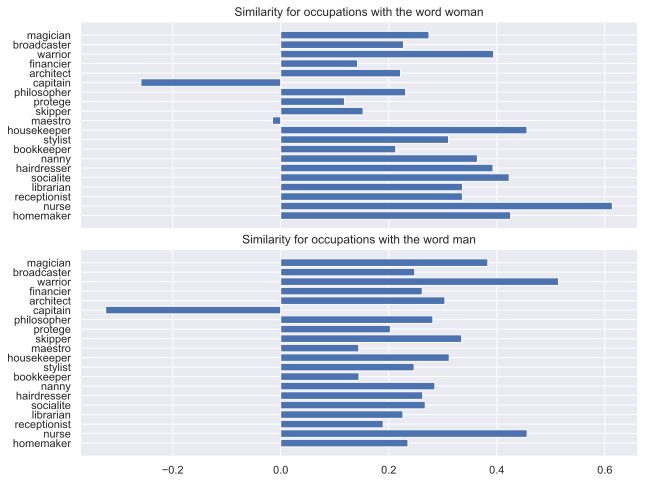

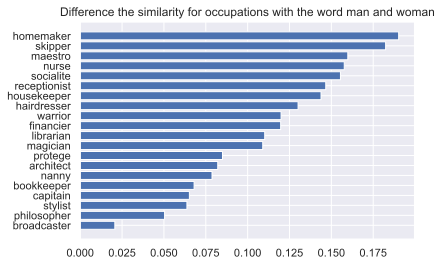

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax[0].barh(occupations,occ_sim_woman, height=0.8)
ax[0].set_title("Similarity for occupations with the word woman")

ax[1].barh(occupations,occ_sim_man, height=0.8)
ax[1].set_title("Similarity for occupations with the word man")

plt.subplots_adjust(hspace=0.1)
plt.show()

plt.barh(occ_sorted,abs_diff_sorted, height=0.8)
plt.title("Difference the similarity for occupations with the word man and woman")
plt.show()

##### Remarks about the three plots above

there is a pretty big difference in the asssociation of some of the words with man and woman, this is especially visible in the third plot that shows the differences in similarity. The occupations 'homemaker' and 'skipper' differ more than 17% in similarity with the words man and woman. The first plot shows that 'nurse' is more than 60% similar to the word woman. While the similarity with man is only about 45% (plot two).

In [34]:
word_vectors.most_similar(positive=['man'], negative=['white'], topn=10)

[('amrozi', 0.4717967212200165),
 ('kidnapper', 0.4600438177585602),
 ('policeman', 0.45492419600486755),
 ('teenager', 0.45344120264053345),
 ('swede', 0.4499233663082123),
 ('kasab', 0.44462642073631287),
 ('attacker', 0.4439505338668823),
 ('quadriplegic', 0.4419060945510864),
 ('trafficker', 0.43809837102890015),
 ('hitman', 0.43660467863082886)]

In [35]:
word_vectors.most_similar(positive=['man'], negative=['black'], topn=10)

[('osman', 0.45180419087409973),
 ('amrozi', 0.42844435572624207),
 ('confessed', 0.4282333254814148),
 ('hamed', 0.42750284075737),
 ('kidnapper', 0.42562878131866455),
 ('kasab', 0.41945093870162964),
 ('lover', 0.41150787472724915),
 ('27-year', 0.40995919704437256),
 ('confesses', 0.409296452999115),
 ('accomplice', 0.40752559900283813)]

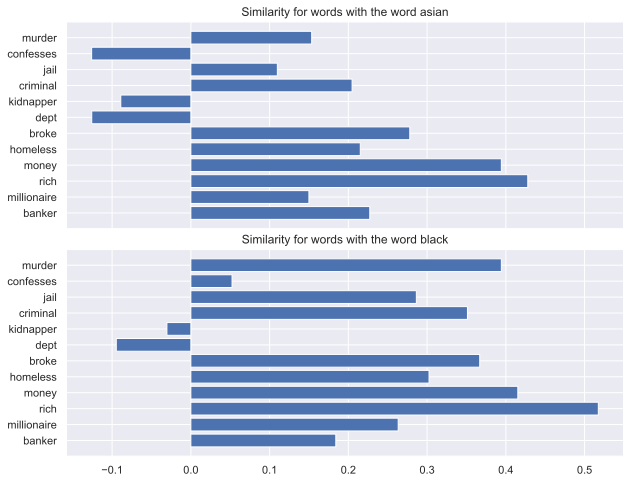

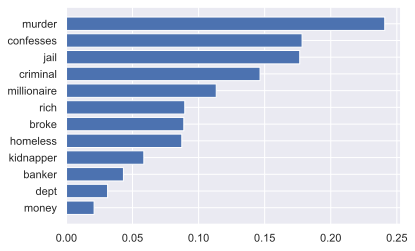

In [36]:
test_words = [
    "banker",
    "millionaire",
    "rich",
    "money",
    "homeless",
    "broke",
    "dept",
    "kidnapper",
    "criminal",
    "jail",
    "confesses",
    "murder"
]

occ_sim_as = []
occ_sim_bl = []

for occ in test_words:
    occ_sim_as.append(word_vectors.similarity(occ, 'asian'))
    occ_sim_bl.append(word_vectors.similarity(occ, 'black'))
    
occ_sim_as = np.array(occ_sim_as)
occ_sim_bl = np.array(occ_sim_bl)

abs_diff = np.abs(occ_sim_as-occ_sim_bl)
abs_diff_sorted = np.sort(abs_diff)
sorted_ids = np.argsort(abs_diff)
occ_sorted = []
for i in sorted_ids:
    occ_sorted.append(test_words[i])
    
fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)

ax[0].barh(test_words,occ_sim_as, height=0.8)
ax[0].set_title("Similarity for words with the word asian")

ax[1].barh(test_words,occ_sim_bl, height=0.8)
ax[1].set_title("Similarity for words with the word black")

plt.subplots_adjust(hspace=0.1)
plt.show()
    
plt.barh(occ_sorted,abs_diff_sorted, height=0.8)
plt.show()

3) The three plots above show that the English data on which GloVe is trained is biased towards making harmful stereotypical associations with words that describe ethnicity (e.g 'black' and 'asian'). The third plot shows that for the words "murder", "confesses" and "jail" there a difference of more than 15% between the similarity with the words 'black' and 'asian'. The first and second plot show that confesses has a positive similarity with 'black' and a negative similarity with 'asian'.